# 1. Import libraries

In [2]:
import os
import simpledbf
import glob
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import rasterio.warp
import rasterio.features
import rasterio.plot
import rasterio.merge
import rasterio.enums
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import pygris
import rioxarray
import folium
from tqdm import tqdm
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# 2. Get NC geometry from pygris

Using the default year of 2021


<Axes: >

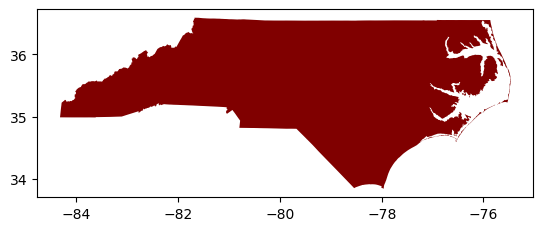

In [3]:
nc = pygris.states(cb = True, cache = True)
nc = nc[nc['NAME'] == 'North Carolina']
nc.plot(color = 'maroon')

# 3. Identify HUC6 regions within NC

Below is an interactive map that shows the different HUC6 catchments that overlap with the boundary of North Carolina. If you hover over each polygon it will tell you which HUC6 catchment it is along with some other metadata

In [4]:
handhuc6 = gpd.read_file('hand_021/hand_021.shp')
huc6s = handhuc6.overlay(nc, how = 'intersection')
huc6s.explore(tiles = 'CartoDB positron', color = 'maroon')

# 4. Print the urls of the HUC6 download links

In [5]:
for url in huc6s['URL']:
    print(url)

https://cfim.ornl.gov/data/HAND/20200601/030101.zip
https://cfim.ornl.gov/data/HAND/20200601/030102.zip
https://cfim.ornl.gov/data/HAND/20200601/030201.zip
https://cfim.ornl.gov/data/HAND/20200601/030202.zip
https://cfim.ornl.gov/data/HAND/20200601/030203.zip
https://cfim.ornl.gov/data/HAND/20200601/030300.zip
https://cfim.ornl.gov/data/HAND/20200601/030401.zip
https://cfim.ornl.gov/data/HAND/20200601/030402.zip
https://cfim.ornl.gov/data/HAND/20200601/030501.zip
https://cfim.ornl.gov/data/HAND/20200601/030601.zip
https://cfim.ornl.gov/data/HAND/20200601/050500.zip
https://cfim.ornl.gov/data/HAND/20200601/060101.zip
https://cfim.ornl.gov/data/HAND/20200601/060102.zip
https://cfim.ornl.gov/data/HAND/20200601/060200.zip


These download links provide the raw HAND files needed for this analysis, though not all of the files are needed for the mapping process. 

Ultimately, I needed a statewide HAND file, statewide catchment file, and a statewide flow line file. I did this using the HAND, catchment, and flowline files from the download links above and the **Merge Raster tool** and the **Merge Vector Layers Vector tool** in **QGIS**.

For the catchment file, I also needed to calculate the percentage of each USGS regression region that each drainage basin falls within for each catchment (from https://pubs.er.usgs.gov/publication/sir20235006/full and https://www.sciencebase.gov/catalog/item/61859000d34ec04fc9c207e9). See the file **regression_region_percentages.py** for reference on this process. 

I also needed to combine the src tables for each HUC6 unit into one file using pandas. See the file **src_combiner.py** for reference in this process.

# 5. Determine the 100-year flows for each catchment using USGS regression equations

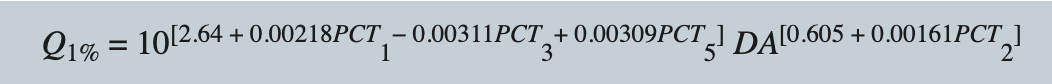

This is the equation from (https://pubs.er.usgs.gov/publication/sir20235006/full) that allows for calculation of the 100-year discharge in ungaged basins all throughout North Carolina (and some other states too). This is why I needed the percentage of each USGS regression region that each catchment falls within.

Take a look at the **catch_DA_flow.py** script to see how I attached the drainage areas to each catchment polygon, as well as how I calculated the 100-year discharges for each catchment.

# 6. Determine which catchments overlap with the FEMA flood map

In order to limit any extra computations, I wanted to know which catchments overlapped with the FEMA flood map. This is helpful because if a catchment doesn't overlap, then I have nothing to calibrate against, so I will skip that catchment and mark it with a "no fema" flag. See the script **fema_flag.py** to see how this is done.

# 7. Determine the initial rating curve functions (RCs) for each catchment 

To allow for greater intercomparison between the stage-discharge relationships from the SRCs and from the USGS field measurements, as well as much faster flood map computation (at the cost of a little approximation), the SRC relationships for each catchment are converted to RCFs taking the form $H = a*Q^b$, where $H$ is the water stage in m, $Q$ is the discharge in $m^3/s$, and both $a$ and $b$ are coefficients pertaining to the stage-discharge relationship in each catchment. See the script **src_power_law.py** to get a sense of how this is accomplished.

# 8. Determine optimal stages for each catchment in NC

I followed the same procedure that I did for the Wake County calibration, where for each catchment I iterated through the minimum and maximum stage values by an increment of 0.025 m of stage at a time. For each stage value, I calculate the flood map, calculate the agreement with the FEMA flood map, and then determine the optimal stage value as the stage that results in the maximum agreement value. See the script **optimal_stages.py** to see how his code looks.

# 9. Calculate the scale factors for each catchment 

Once again, just following the same procedure that I did for the Wake County calibration. First I create a new power law relationship for each catchment that relates stage and the $A*R^{2/3}$ from each SRC. This is needed so I can calculate the ratio of $A*R^{2/3}$ between the initial stage and the optimal stage which is required to calculate the adjusted Manning's $n$ coefficient and the SRC RCF scale factor. Take a look at the **scale_factors.py** script for the code required for these calculations.

# 10. Make a HAND vs. FEMA agreement map for all of NC

Taking the output from step 9, I made some final agreement maps and plots for all of NC. See the script **agreement_figures.py** to see how this was accomplished